# MNIST by Softmax

In [228]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [229]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [230]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# MNIST Data

In [231]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

# Dataset 구성 확인

In [232]:
# MNIST dataset 크기
print("train data 크기:", len(mnist_train), "      ", "test data 크기:",len(mnist_test))

train data 크기: 60000        test data 크기: 10000


In [248]:
# i번째 data확인
i=5343
print(type(mnist_train[i]), len(mnist_train[i]))

<class 'tuple'> 2


위에서 train data가 60000개 이며, 그 중에 i번째 성분을 골라서 확인해보니, tuple로 2개의 요소가 묶여져 있음을 확인

In [235]:
first, second= mnist_train[i]
print("first type :", type(first), "       first len :", len(first), "         first size :", first.size())
print("second type :", type(second), "      second :", second)

first type : <class 'torch.Tensor'>        first len : 1          first size : torch.Size([1, 28, 28])
second type : <class 'int'>       second : 8


2개의 tuple을 분리하여 first 성분을 확인해보니, 1 x 28 x 28 행렬(image)인 Tensor이고, second는 이 행렬의 Label 정보(정답)을 가지고 있다.

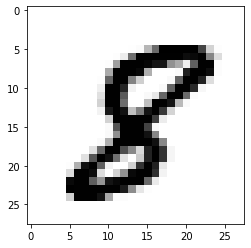

In [236]:
# image가 3차원이므로, 의미없는 1을 없애고 2차원으로 만들기 위해 view(28, 28) 진행하여 image확인
plt.imshow(first.view(28, 28), cmap='Greys', interpolation='nearest')

# Data loading

In [237]:
data_loader = DataLoader(dataset=mnist_train, batch_size=100, shuffle=True, drop_last=True)

In [11]:
print(len(data_loader), type(data_loader))

600 <class 'torch.utils.data.dataloader.DataLoader'>


* 전체 크기가 60000개인 data를 100개의 batch_size로 나누므로, data_loader는 600개 data로 구성됨.
* 이 때, data_loader의 한개 data는 자동으로 '100 x input차원'의 행렬이 된다.

# Modeling
* 1-1. Linear Classification 함수 1개 사용
* 1-2. class로 MyModel을 만들고, 함수 3개 사용

In [0]:
# 1-1.
# softmax의 Linear 함수를 위해 28 x 28 image를 1차원으로 바꾸고, 10개 숫자 분류를 해야하므로,
MyModel = nn.Linear(784, 10, bias=True).to(device)

# cost 정의
criterion = nn.CrossEntropyLoss().to(device)   # 소프트맥스 함수 포함됨

In [238]:
# 1-2. 결과적으로 Linear 함수를 3회를 추가 진행해도 1회 한 것과 큰 차이 없으며, Modeling 실습으로 진행. 

import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.myL1 = nn.Linear(784, 380, bias=True).to(device)   # 380은 임의 분류 수
        self.myL2 = nn.Linear(380, 100, bias=True).to(device)   # 100은 임의 분류 수
        self.myL3 = nn.Linear(100, 10, bias=True).to(device)       
        
        self.sigmoid = torch.nn.Sigmoid().to(device)

           
    def forward(self, x):
        out1 = self.sigmoid (self.myL1(x))               # 뷴류기로 softmax를 2회 이상쓰면, cost 감소 안함.
        out2 = self.sigmoid (self.myL2(out1))            # softmax의 output이 1이하의 소수라서 backward 불리.
        prediction = torch.log(F.softmax(self.myL3(out2), dim=1))   # cost 계산을 위해 log 취함
        
        return prediction

model = MyModel()

In [239]:
# cost와 optimizer 정의

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [240]:
training_epochs = 15

for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 X는 (100, 784)
        X = X.view(-1, 28 * 28).to(device)
        # Y는 0 ~ 9의 정수, cost 함수를 원-핫 인코딩이 필요없는 F.nll_loss를 사용함.
        Y = Y.to(device)

        hypothesis = model(X)

        #1-1 Model Cost (적용시 아래 # 주석 제거)
        #cost = criterion(hypothesis, Y)
        
        #1-2 Model Cost
        cost = F.nll_loss(hypothesis, Y).to(device) 
        
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 2.241573572
Epoch: 0002 cost = 1.218362689
Epoch: 0003 cost = 0.632513046
Epoch: 0004 cost = 0.472460538
Epoch: 0005 cost = 0.409027487
Epoch: 0006 cost = 0.373611778
Epoch: 0007 cost = 0.349982381
Epoch: 0008 cost = 0.332254589
Epoch: 0009 cost = 0.318131804
Epoch: 0010 cost = 0.305770129
Epoch: 0011 cost = 0.294216812
Epoch: 0012 cost = 0.283297211
Epoch: 0013 cost = 0.273458868
Epoch: 0014 cost = 0.263514727
Epoch: 0015 cost = 0.254387200
Learning finished


# Test Data

In [258]:
# 서두에서 mnist_test가 10000개임을 확인했고, j번째 data확인
j=540
print(type(mnist_test[j]), len(mnist_test[j]))

<class 'tuple'> 2


In [259]:
test_first, test_second= mnist_test[j]
print("first type :", type(test_first), "       first len :", len(test_first), "         first size :", test_first.size())
print("second type :", type(test_second), "      second :", test_second)

first type : <class 'torch.Tensor'>        first len : 1          first size : torch.Size([1, 28, 28])
second type : <class 'int'>       second : 5


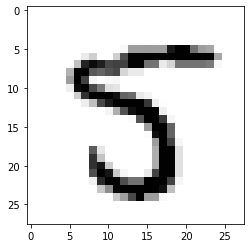

In [260]:
plt.imshow(test_first.view(28, 28), cmap='Greys', interpolation='nearest')

# Model 검증
* 위에서 mnist_test[j]의 image값인 test_first와 Label인 test_second로 model 검증

In [276]:
# 우선 위 mnist_test[j]를 검증
X_test1 = test_first.view(-1, 28 * 28).float().to(device)     # model 함수 input 차원과 맞춤
Y_test1 = test_second

prediction = torch.argmax(model(X_test1),1)
print(prediction)

print(prediction == Y_test1)

tensor([5])
tensor([True])


In [280]:
# minist_test 모든 data에 대해 정확도 통계 계산
# test_data, test_labels method로 전체 data 계산

with torch.no_grad():             # gradient 계산 않음.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9207000136375427


* Reference

 -. https://wikidocs.net/60324